Source: https://qiskit.org/ecosystem/machine-learning/tutorials/03_quantum_kernel.html

# Setting up the environment

In [1]:
from qiskit_machine_learning.datasets import ad_hoc_data
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC
from qiskit_machine_learning.algorithms import QSVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 12345

C:\Users\Picrik\AppData\Local\Temp\ipykernel_25708\1366543013.py:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.state_fidelities import ComputeUncompute


# New functions

In [2]:
def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

# The ad hoc data set

In [9]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

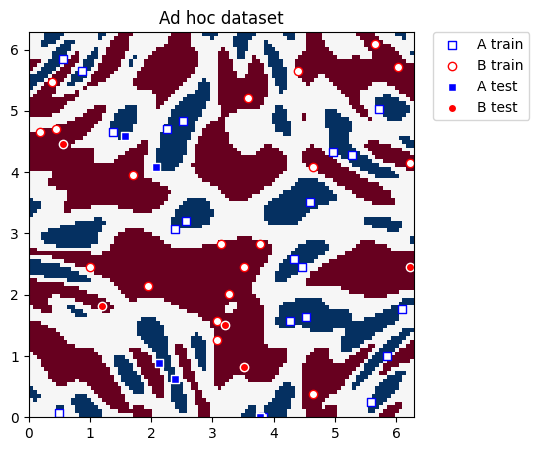

In [10]:
# plot data
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

In [7]:
# Defining the quantum kernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

## Classification with SVC

In [8]:
# Kernel as a callable function
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(train_features, train_labels)

adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 1.0


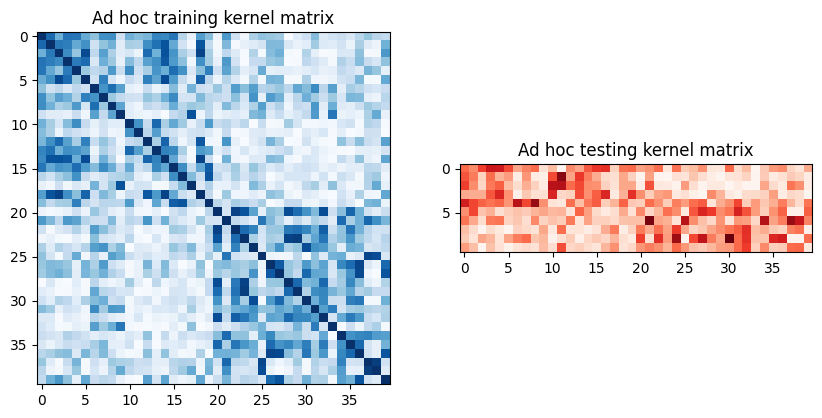

In [9]:
# Precomputed kernel matrix
# Visualization
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

In [10]:
# Test on the precomputed matrices
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


# Classification with QSVC

In [11]:
qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


# Evaluation of the models used

In [12]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       1.00
SVC using precomputed kernel matrix     |       1.00
QSVC                                    |       1.00


# Clustering

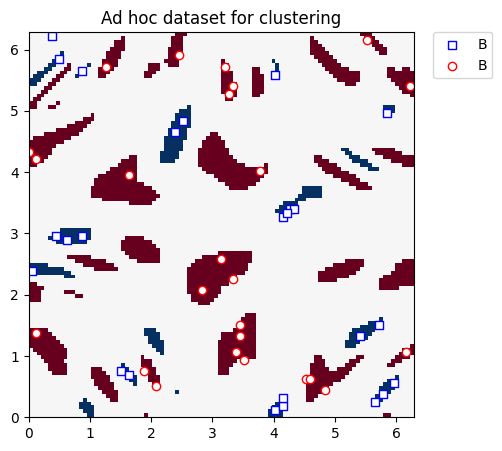

In [13]:
# Creating dataset
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

# Plot the dataset
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

# A label plot
plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "B")

# B label plot
plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for clustering")

plt.show()

# Defining the Quantum Kernel

In [14]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

adhoc_kernel = FidelityQuantumKernel(feature_map=adhoc_feature_map)

# Clustering with the Spectral Clustering Model

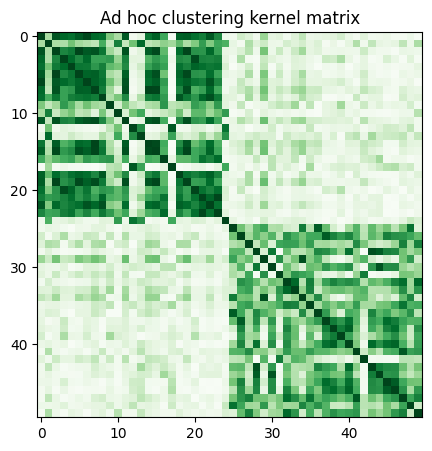

In [15]:
adhoc_matrix = adhoc_kernel.evaluate(x_vec=train_features)

plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(adhoc_matrix), interpolation="nearest", origin="upper", cmap="Greens")
plt.title("Ad hoc clustering kernel matrix")
plt.show()

In [16]:
adhoc_spectral = SpectralClustering(2, affinity="precomputed")

cluster_labels = adhoc_spectral.fit_predict(adhoc_matrix)

cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)

print(f"Clustering score: {cluster_score}")

Clustering score: 0.7287008798015754


# Kernel Principal Component Analysis

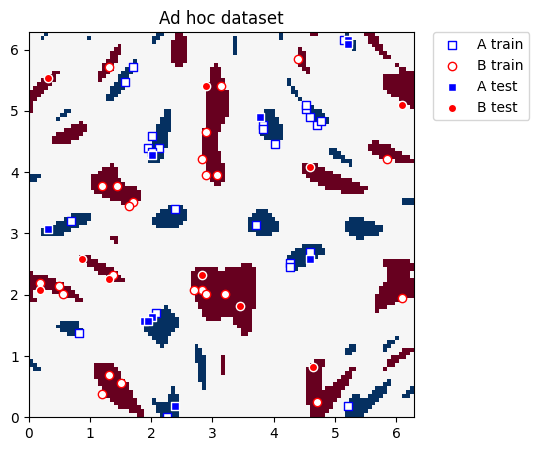

In [17]:
# Creating dataset

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=10,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

# Plot dataset
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)


# Defining the Quantum Kernel

In [18]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")
qpca_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
matrix_train = qpca_kernel.evaluate(x_vec=train_features)
matrix_test = qpca_kernel.evaluate(x_vec=test_features, y_vec=test_features)

# Comparison of Kernel PCA on gaussian and quantum kernel

In [19]:
kernel_pca_rbf = KernelPCA(n_components=2, kernel="rbf")
kernel_pca_rbf.fit(train_features)
train_features_rbf = kernel_pca_rbf.transform(train_features)
test_features_rbf = kernel_pca_rbf.transform(test_features)

kernel_pca_q = KernelPCA(n_components=2, kernel="precomputed")
train_features_q = kernel_pca_q.fit_transform(matrix_train)
test_features_q = kernel_pca_q.fit_transform(matrix_test)

logistic_regression = LogisticRegression()
logistic_regression.fit(train_features_q, train_labels)

logistic_score = logistic_regression.score(test_features_q, test_labels)
print(f"Logistic regression score: {logistic_score}")

Logistic regression score: 1.0


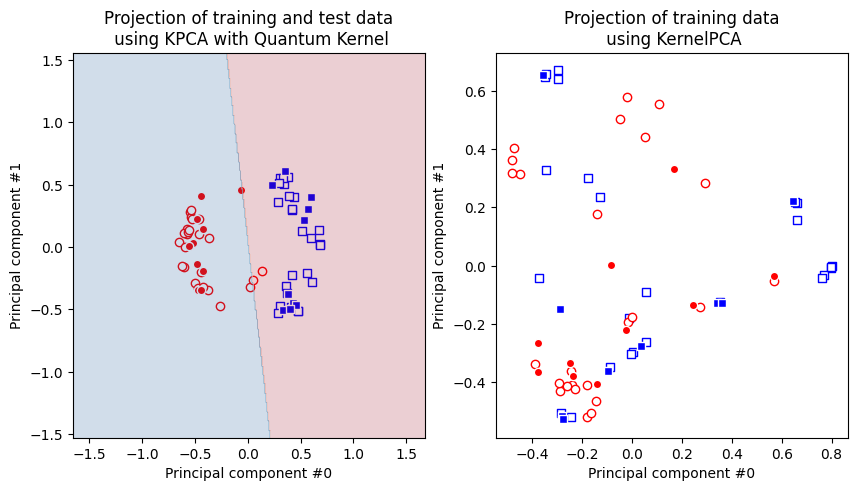

In [20]:
# Plot the results

fig, (q_ax, rbf_ax) = plt.subplots(1, 2, figsize=(10, 5))


plot_features(q_ax, train_features_q, train_labels, 0, "s", "w", "b", "A train")
plot_features(q_ax, train_features_q, train_labels, 1, "o", "w", "r", "B train")

plot_features(q_ax, test_features_q, test_labels, 0, "s", "b", "w", "A test")
plot_features(q_ax, test_features_q, test_labels, 1, "o", "r", "w", "A test")

q_ax.set_ylabel("Principal component #1")
q_ax.set_xlabel("Principal component #0")
q_ax.set_title("Projection of training and test data\n using KPCA with Quantum Kernel")

# Plotting the linear separation
h = 0.01  # step size in the mesh

# create a mesh to plot in
x_min, x_max = train_features_q[:, 0].min() - 1, train_features_q[:, 0].max() + 1
y_min, y_max = train_features_q[:, 1].min() - 1, train_features_q[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

predictions = logistic_regression.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
predictions = predictions.reshape(xx.shape)
q_ax.contourf(xx, yy, predictions, cmap=plt.cm.RdBu, alpha=0.2)

plot_features(rbf_ax, train_features_rbf, train_labels, 0, "s", "w", "b", "A train")
plot_features(rbf_ax, train_features_rbf, train_labels, 1, "o", "w", "r", "B train")
plot_features(rbf_ax, test_features_rbf, test_labels, 0, "s", "b", "w", "A test")
plot_features(rbf_ax, test_features_rbf, test_labels, 1, "o", "r", "w", "A test")

rbf_ax.set_ylabel("Principal component #1")
rbf_ax.set_xlabel("Principal component #0")
rbf_ax.set_title("Projection of training data\n using KernelPCA")
plt.show()

In [21]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright